In this report, I set out to answer two primary questions:

- What are the primary considerations in modeling the factor selections?

My primary considerations were to simplify the number of factors from individual ids to subthemes and themes so as to reduce the number of features, which would improve the performance of models. Additionally, given that only 2 years had governance ids, I originally intended on interpolating missing years with the earliest available governance data, but felt it would make most sense to only compare returns with governance of the same year, especially in the comtemporary mercurial political and economical climate where changes can occur overnight. Lastly, I avoided approaches that would remove interpretability of the factors that affect return and volatility data such as PCA, as we are interested in the effects of features.

- How do you separate the firm effect from the market?

To separate the firm effect from the market, subtract the SPY return from all firm's returns of the same day. This isolates the changes of the return for each firm, allowing for computation of longer term returns and volatility.

Executive Summary:

Daily return and sustainability/diversity governance data was taken for 43 companies over the course of 5 years, of which only 2 had governance data. Each of the the governance data ids could be grouped into Subthemes and in turn overarching Themes, forming simplifying levels or granularities of features for modeling. At each level, the features are not strongly correlated, and there are few outliers in the yearly returns and volatility data. 

By modeling both yearly forward returns and volatility from the governance data from the same year, we find that using a Gradient Boosting model for volatility data at the subtheme level has an R2 of 39%. The most important features were Subthemes Q, V, W, S, and P. Similar levels of success where the yearly returns were modeled using a Gradient Boosting model reached an R2 of 36% at the theme level. However the interpretability of the two overarching themes masks the changes of the governance ids, forcing our hand to investigate a finer granularity.

Using an XGBoost model for forward returns, subthemes V, W, S, Q, and X were found to be the most important towards modeling the forward returns, albeit with a low R2 value of 0.03.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor

from sklearn.svm import SVR
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings('ignore')

## Data Preprocessing

In [2]:
df1 = pd.read_excel(open('ds.xlsx', 'rb')) # data.xlsx
print(df1['Industry'].unique())
df1['Industry'] = df1['Industry'].map({'Semiconductors & Semiconductor Equipment': 0,
                                     'Software': 1, 
                                     'Communications Equipment': 2,
                                     'Diversified Telecommunication Services': 3,
                                     'Wireless Telecommunication Services': 4,
                                     'IT Services': 5,
                                     'Interactive Media & Services': 6,
                                     'Technology Hardware, Storage & Peripherals': 7,
                                     'Broadline Retail': 8,
                                     'Electronic Equipment, Instruments & Components': 9,
                                     'Hotels, Restaurants & Leisure': 10})
print(df1.shape)
df1.head()

['Semiconductors & Semiconductor Equipment' 'Software'
 'Communications Equipment' 'Diversified Telecommunication Services'
 'Wireless Telecommunication Services' 'IT Services'
 'Interactive Media & Services'
 'Technology Hardware, Storage & Peripherals' 'Broadline Retail'
 'Electronic Equipment, Instruments & Components'
 'Hotels, Restaurants & Leisure']
(4664, 8)


,Company,Year,Industry,Sr.,Criteria ID,Overarching Theme,Sub-Theme,Score
0,AMAT,2020,0,1,C1,Theme A,Sub-Theme P,1
1,AMAT,2020,0,2,C3,Theme A,Sub-Theme P,1
2,AMAT,2020,0,3,C4,Theme A,Sub-Theme P,1
3,AMAT,2020,0,4,C5,Theme A,Sub-Theme Q,1
4,AMAT,2020,0,5,C6,Theme A,Sub-Theme Q,1


At a glance one can see that Industry of each company can be mapped to integers, since the data is currently in strings. Additionally, it would be highly convenient to condense the data into a manner where information for each company and year can be reliably accessed, possibly in the same row rather than in separate columns

In [3]:
# Fet groupings of each Theme and Subtheme

groups = []
unique1 = df1.groupby('Overarching Theme')['Sr.'].unique()
for g in unique1:
    groups.append(list(g))

subgroups = []
unique2 = df1.groupby('Sub-Theme')['Sr.'].unique()
for g in unique2:
    subgroups.append(list(g))

allg = [x for xs in groups for x in xs]

print(unique1)
print(unique2)

# Pivot the table such that every Governance Index per company and year can be accessed in the same row

wide_df1 = df1.pivot_table(index = ['Company', 'Year', 'Industry'],
                           columns = 'Sr.',
                           values = 'Score')

# Compute the net governance scores in each category


wide_df1['Theme A'] = wide_df1[groups[0]].mean(axis=1)
wide_df1['Theme B'] = wide_df1[groups[1]].mean(axis=1)

wide_df1['SubTheme P'] = wide_df1[subgroups[0]].mean(axis=1)
wide_df1['SubTheme Q'] = wide_df1[subgroups[1]].mean(axis=1)
wide_df1['SubTheme S'] = wide_df1[subgroups[2]].mean(axis=1)
wide_df1['SubTheme R'] = wide_df1[subgroups[3]].mean(axis=1)
wide_df1['SubTheme V'] = wide_df1[subgroups[4]].mean(axis=1)
wide_df1['SubTheme W'] = wide_df1[subgroups[5]].mean(axis=1)
wide_df1['SubTheme X'] = wide_df1[subgroups[6]].mean(axis=1)
#wide_df1['Mean Score'] = wide_df1[allg].mean(axis=1)

df1_agg = wide_df1.reset_index()

Overarching Theme
Theme A    [1, 2, 3, 4, 5, 6, 10, 16, 17, 18, 19, 20, 21,...
Theme B    [46, 47, 48, 49, 53, 54, 55, 56, 57, 60, 61, 6...
Name: Sr., dtype: object
Sub-Theme
Sub-Theme P                            [1, 2, 3, 18, 60, 61, 69]
Sub-Theme Q                    [4, 5, 6, 10, 46, 47, 48, 49, 62]
Sub-Theme S             [16, 17, 19, 20, 21, 53, 54, 55, 56, 57]
Sub-Theme T                             [22, 23, 24, 25, 27, 63]
Sub-Theme V                                 [38, 39, 40, 41, 42]
Sub-Theme W    [71, 72, 73, 75, 78, 79, 80, 81, 84, 85, 87, 8...
Sub-Theme X                                             [76, 77]
Name: Sr., dtype: object


In [4]:
# As we do not have governance data for the years 2021, 2022, aand 2024, 
# we interpolate using the governance data from the earliest available governance data, in case we need them.

years_to_add = [2021, 2022, 2024]
df_expanded = df1_agg.copy()

df_ffill = df1_agg[df1_agg['Year'] == 2020].copy()
df_ffill['Year'] = 2021

df_ffill2 = df1_agg[df1_agg['Year'] == 2020].copy()
df_ffill2['Year'] = 2022

df_bfill = df1_agg[df1_agg['Year'] == 2023].copy()
df_bfill['Year'] = 2024

df_expanded = pd.concat([df_expanded, df_ffill, df_ffill2, df_bfill], ignore_index=True)
df_expanded = df_expanded.sort_values(by=['Company', 'Year'])

In [5]:
df2 = pd.read_excel(open('stockret.xlsx', 'rb')) # stockret.xlsx
df2.isna().sum()

AAPL      1
ABNB    239
ACN       1
ADI       1
ADSK      1
AMAT      1
AMD       1
AMZN      1
ANET      1
APH       1
AVGO      1
CDNS      1
CRM       1
CSCO      1
CTSH      1
DDOG      1
FTNT      1
GOOG      1
HPQ       1
IBM       1
INTC      1
IT        1
KLAC      1
MCHP      1
META      1
MPWR      1
MRVL      1
MSI       1
MU        1
NOW       1
NVDA      1
ORCL      1
PANW      1
PLTR    189
QCOM      1
ROP       1
SNOW    179
SNPS      1
T         1
TEAM      1
TMUS      1
TXN       1
VZ        1
SPY       1
date      0
dtype: int64

Several tickers do not have returns on certain dates. To address this, those values will be made to be 0 after considering the market returns, resulting in them being aligned perfectly with the market effect.

In [6]:
df2["Day"] = df2.groupby("date").cumcount() + 1
df2 = df2.rename(columns={'date': 'Year'})

tickers = df2.columns.difference(["SPY", "Year", "day"])  # Exclude non-ticker columns
df_excess = df2.copy()
df_excess[tickers] = df2[tickers].subtract(df2["SPY"], axis=0) # subtract market effect

df_excess = df_excess.fillna(0) # if there's no data, fill na as 0, synchronous with market effect

for_rets = df_excess.groupby("Year")[tickers].apply(lambda x: (1 + x).prod() - 1) # yearly return
vol = df_excess.groupby("Year")[tickers].std() # volatility

df_for = for_rets.reset_index().melt(id_vars=["Year"], var_name="Company", value_name="Forward Return")
df_vol = vol.reset_index().melt(id_vars=["Year"], var_name="Company", value_name="Vol")

#df_for['Year'] = df_for['Year'] - 1

df_m1 = pd.merge(df_expanded, df_for, on=['Company','Year'], how='inner') # merge return and vol with governance
df_fin1 = pd.merge(df_m1, df_vol, on=['Company','Year'], how='inner')

We'll be merging on the assumption that the governance ratings for Year X will best the annual returns and volatility of the same year.

In [7]:
df_lim = df_fin1.loc[(df_fin1['Year'] == 2020) | (df_fin1['Year'] == 2023)] # only consider years with governance
df = df_lim.iloc[:, 2:] # remove index and ticker

df_ret = df["Forward Return"]
df_vol = df["Vol"]

features = df.drop(columns=["Forward Return", "Vol"])

features.head()


,Industry,1,2,3,4,5,6,10,16,17,...,91,Theme A,Theme B,SubTheme P,SubTheme Q,SubTheme S,SubTheme R,SubTheme V,SubTheme W,SubTheme X
0,7,0,1,1,1,0,0,0,1,0,...,0,0.434783,0.233333,0.428571,0.444444,0.3,0.000000,1.0,0.142857,0.0
3,7,0,1,1,1,1,1,1,1,0,...,0,0.608696,0.566667,0.428571,0.777778,0.5,0.166667,1.0,0.571429,1.0
5,10,0,0,0,1,1,0,0,0,0,...,0,0.260870,0.266667,0.142857,0.444444,0.4,0.000000,0.2,0.285714,0.0
8,10,0,1,1,0,0,1,0,0,0,...,0,0.347826,0.333333,0.428571,0.444444,0.4,0.166667,0.4,0.285714,0.0
10,5,0,1,1,1,1,0,1,1,1,...,0,0.565217,0.433333,0.428571,0.555556,0.7,0.333333,0.2,0.571429,0.0


## Feature Analysis

Categorize the overall governance of each Theme and Subtheme by taking the sum of the IDs within each category. The high number of features stemming from the governance IDs is cause for concern resulting in a poorly trained model, thus the theme groupings will be helpful to have in the future.

<Axes: xlabel='Sr.', ylabel='Sr.'>

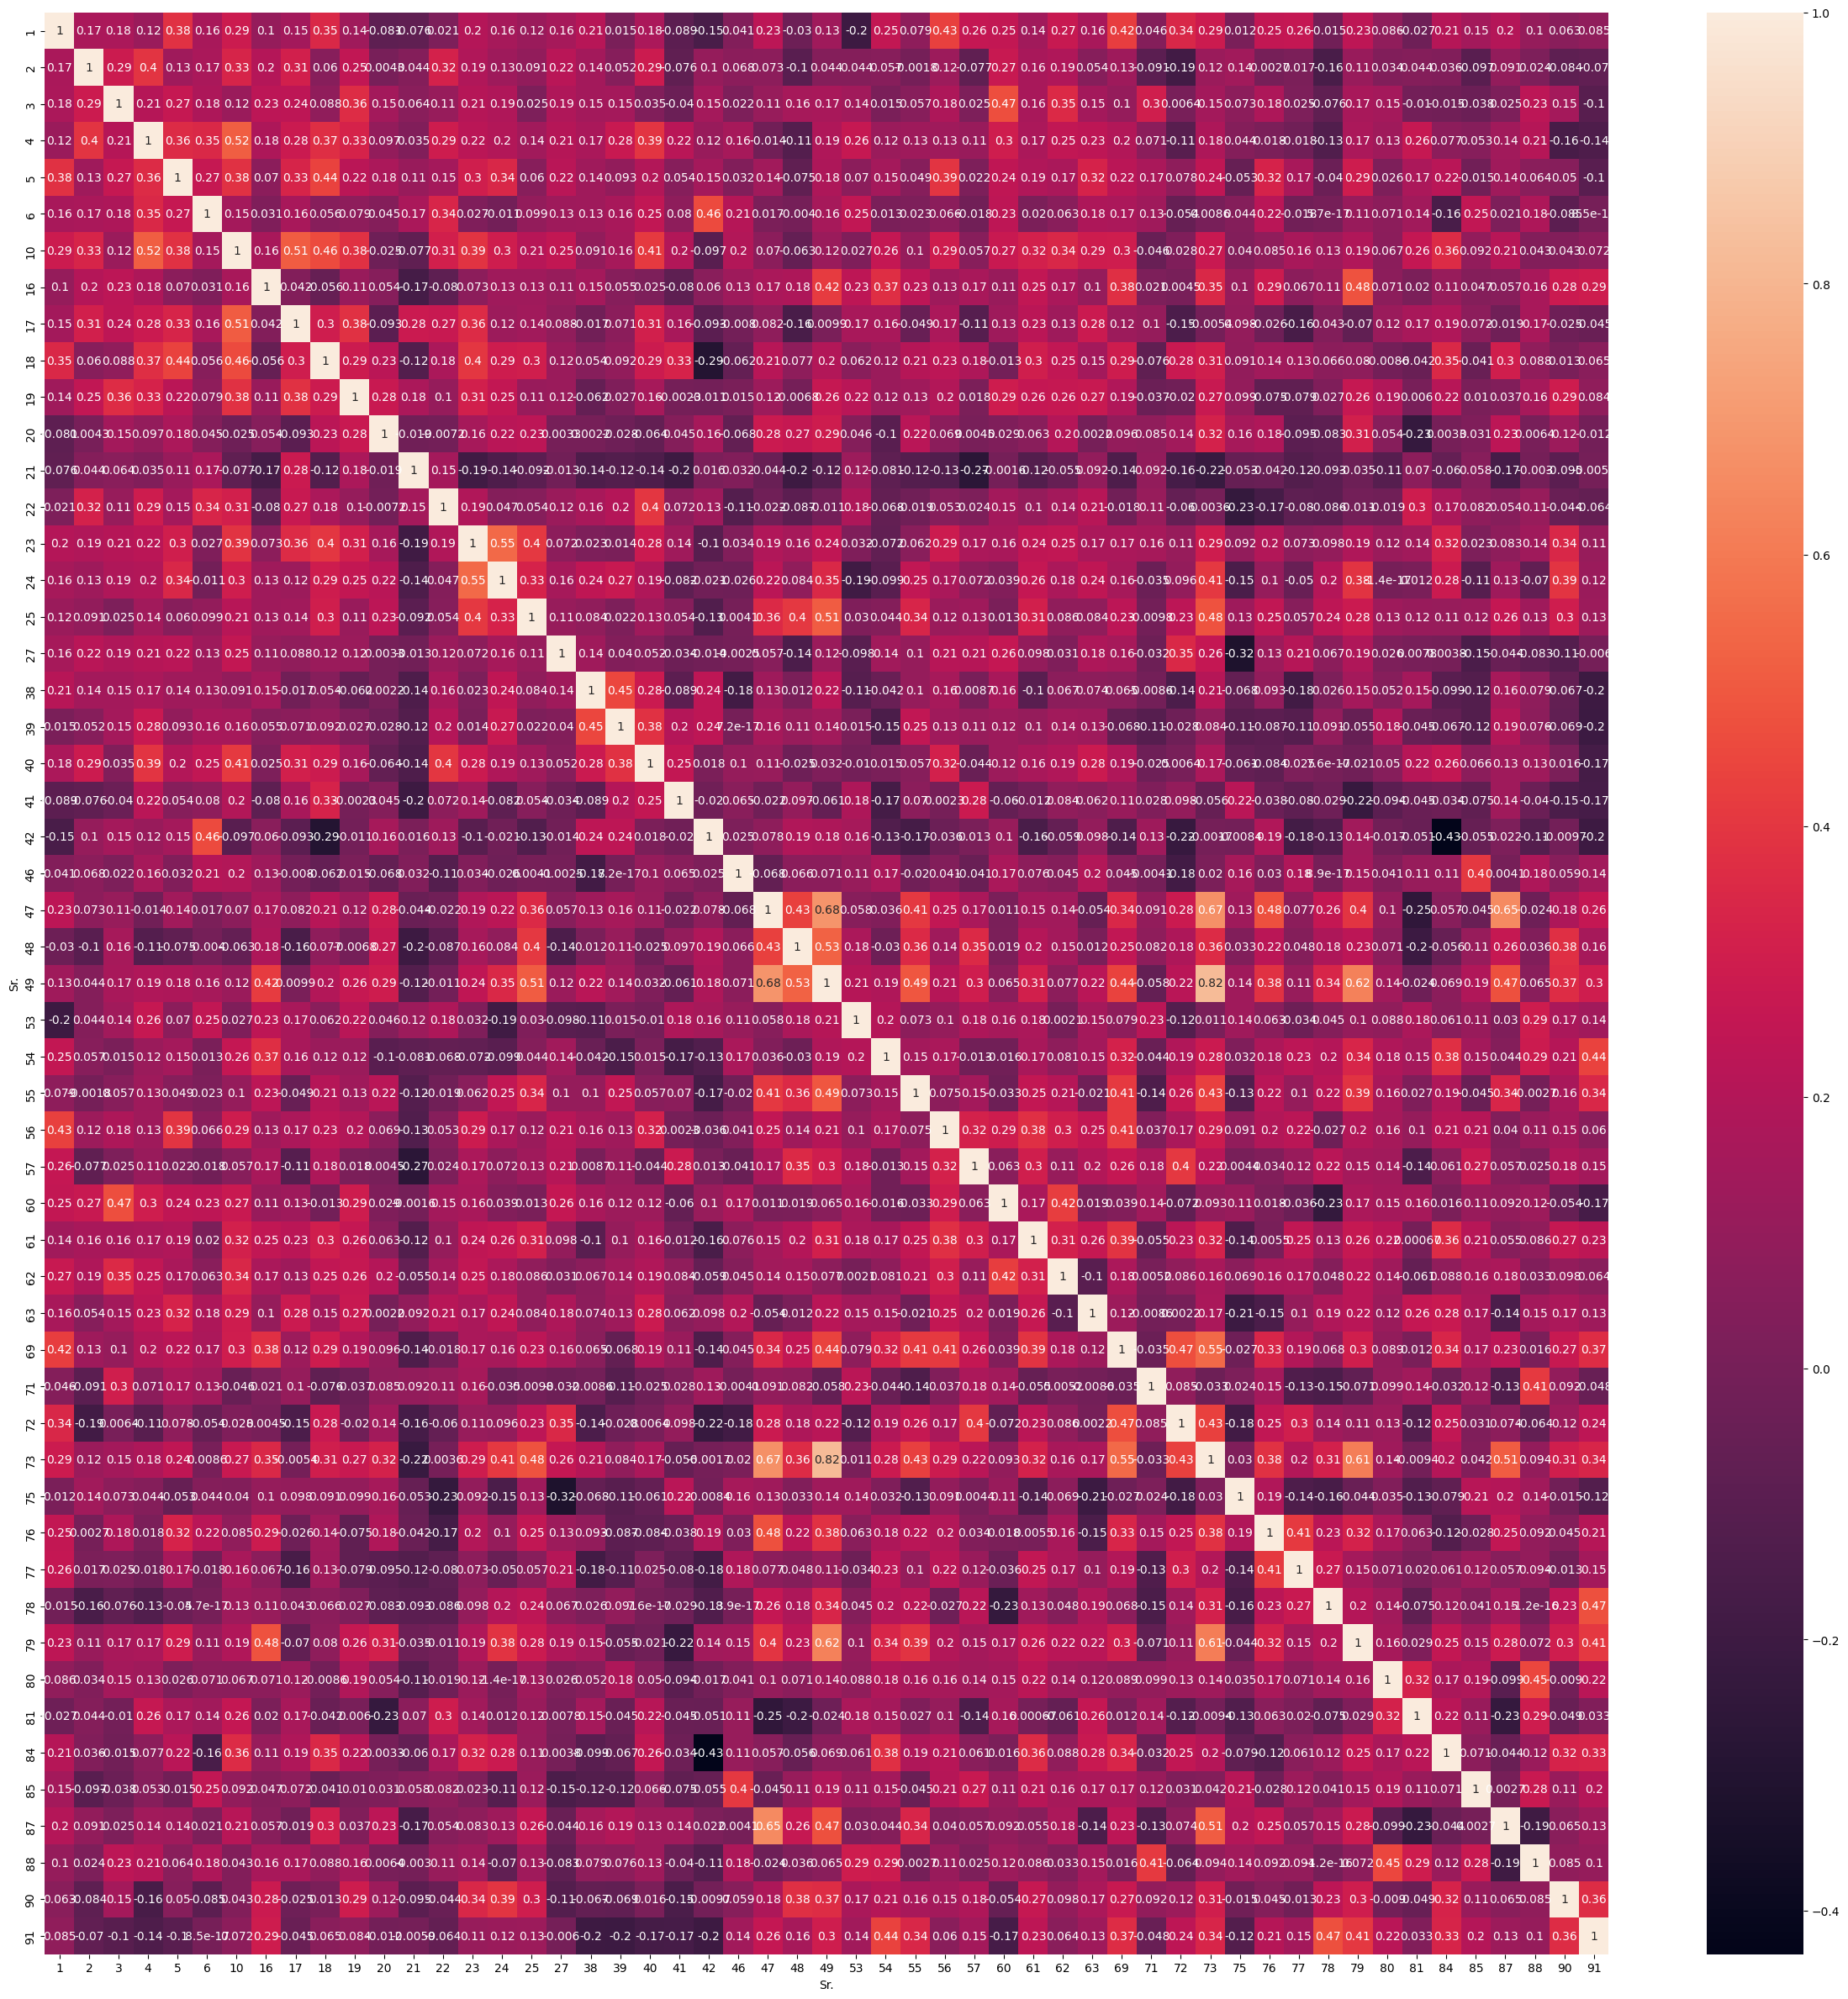

In [8]:
plt.figure(figsize=(30,30))
sns.heatmap(df1_agg[allg].corr(), annot=True)

In terms of feature selection most features do not have strong correlation with one another within the level, with the exception of SubTheme W and Theme A. Since I plan on running analyses at each granularity separately, no highly correlated features need to be removed.

<Axes: xlabel='Sr.', ylabel='Sr.'>

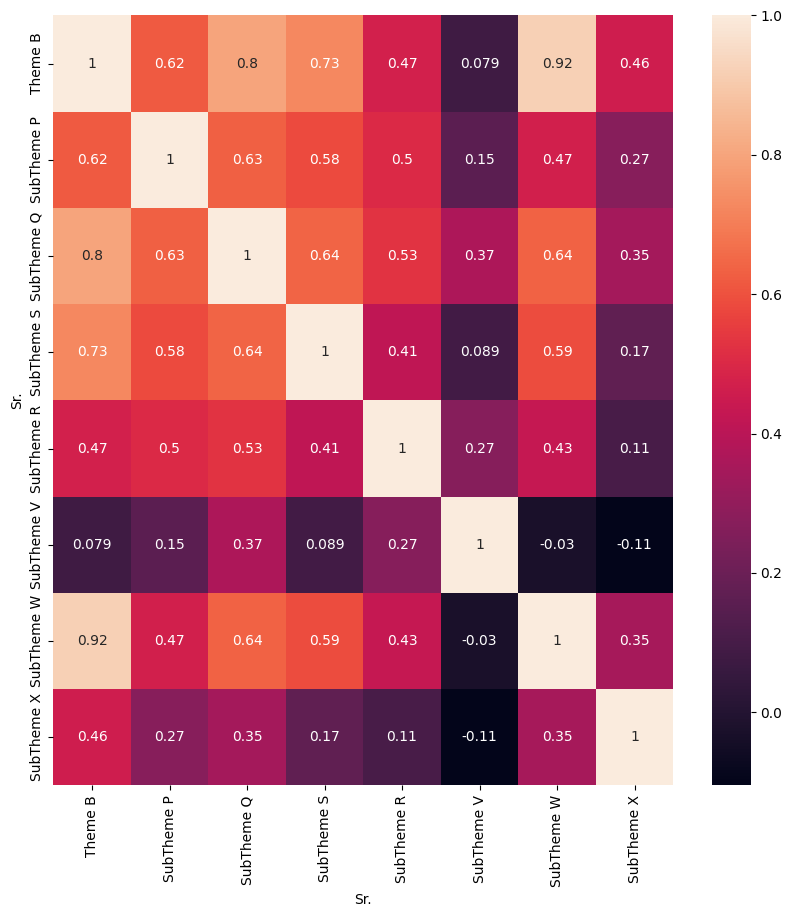

In [9]:
plt.figure(figsize=(10,10))
sns.heatmap(df1_agg.iloc[:, 57:].corr(), annot=True)

Here we address the second question: How does one separate the market effect from the firm? By subtracting the SPY ticker from each firm ticker on the same day, we can isolate the individual firm's effects, and in doing so, can calculate the isolated yearly return and volatility for each year. 

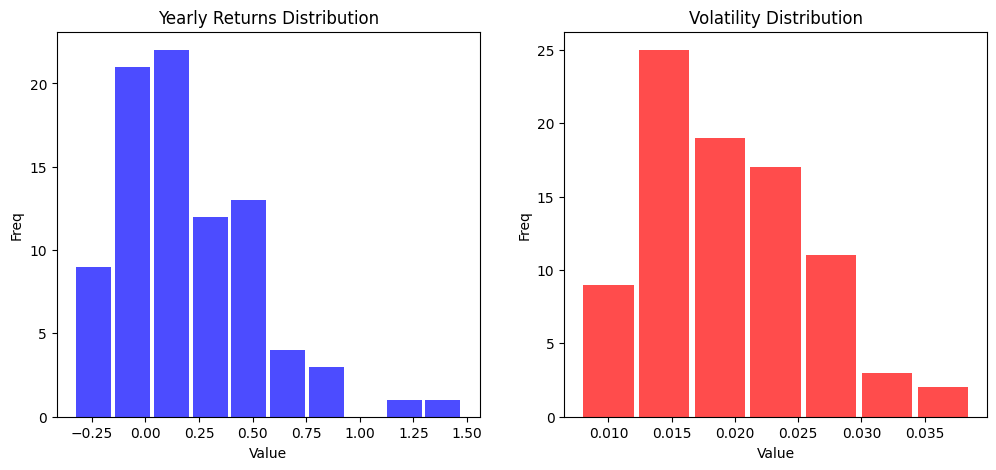

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))  


axes[0].hist(df['Forward Return'], bins=10, color='blue', alpha=0.7, rwidth=0.9)
axes[0].set_title("Yearly Returns Distribution")
axes[0].set_xlabel("Value")
axes[0].set_ylabel("Freq")


axes[1].hist(df['Vol'], bins=7, color='red', alpha=0.7, rwidth=0.9)
axes[1].set_title("Volatility Distribution")
axes[1].set_xlabel("Value")
axes[1].set_ylabel("Freq")

plt.show()

Volatility has a positive skew, making sense as stock volatility is ideally 0, while yearly returns is closest to 0 with a few positive outliers. Due to the low quantity of data (86 rows), we will not prune the outliers.

## Data Modelling

In [11]:
def modelling(X, y, model_title):
    
    scaler = StandardScaler()    
    X_scaled = scaler.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.1, random_state=42)
    
    # Try three different regression approaches
    models = {
        "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
        "Linear Regression": LinearRegression(),
        "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    }

    print("---", model_title, "---")
    print(" ")
    for model_name, model in models.items():
        results = []
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        
        results.append([model_name, round(mae,2), round(mse,2), round(r2,2)])
        results_df = pd.DataFrame(results, columns=["Model", "MAE", "MSE", "R²"])
        print(results_df)
        print(" ")
        
        if model_name == 'Random Forest':
            df_feat = pd.DataFrame({'Feature': X.columns, 'Importance': model.feature_importances_})
            df_feat = df_feat.sort_values(by="Importance", ascending=False)
            print(df_feat.head())
        elif model_name == 'Linear Regression':
            feature_importance = np.abs(model.coef_)
            df_feat = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})
            df_feat = df_feat.sort_values(by="Importance", ascending=False)
            print(df_feat.head())
        elif model_name == 'Gradient Boosting':
            df_feat = pd.DataFrame({'Feature': X.columns, 'Importance': model.feature_importances_})
            df_feat = df_feat.sort_values(by="Importance", ascending=False)
            print(df_feat.head())
        print(" ")


In [12]:
modelling(features.iloc[:, :54], df_ret, "Forward Return - ID")
modelling(features.iloc[:, 56:], df_ret, "Forward Return - SubThemes")
modelling(features.iloc[:, 54:56], df_ret, "Forward Return - Themes")

--- Forward Return - ID ---
 
           Model   MAE   MSE    R²
0  Random Forest  0.22  0.07 -0.69
 
     Feature  Importance
0   Industry    0.166877
44        78    0.096069
38        71    0.056847
27        49    0.051433
4          4    0.047837
 
               Model   MAE  MSE    R²
0  Linear Regression  0.48  0.3 -6.08
 
   Feature  Importance
29      54    0.224337
38      71    0.171879
53      91    0.154122
7       10    0.145152
40      73    0.139814
 
               Model   MAE   MSE    R²
0  Gradient Boosting  0.23  0.08 -0.79
 
     Feature  Importance
0   Industry    0.209333
44        78    0.121222
38        71    0.095995
29        54    0.050564
4          4    0.046501
 
--- Forward Return - SubThemes ---
 
           Model   MAE   MSE    R²
0  Random Forest  0.18  0.06 -0.32
 
      Feature  Importance
4  SubTheme V    0.201333
5  SubTheme W    0.176877
2  SubTheme S    0.173634
1  SubTheme Q    0.164503
0  SubTheme P    0.132948
 
               Model   MAE   

While many of the R^2 values are negative, using the gradient boosting model at the Overarching Theme level results in an R^2 of 0.36. While this approach has the best metrics, the interpretability leaves much to be desired: "What can we learn from the overarching themes themselves?". We'll have to look more closely.

In [13]:
modelling(features.iloc[:, :54], df_vol, "Volatility - ID")
modelling(features.iloc[:, 56:], df_vol, "Volatility - SubThemes")
modelling(features.iloc[:, 54:56], df_vol, "Volatility - Themes")

--- Volatility - ID ---
 
           Model  MAE  MSE    R²
0  Random Forest  0.0  0.0 -0.18
 
     Feature  Importance
4          4    0.333843
0   Industry    0.112150
8         16    0.036888
35        62    0.034732
30        55    0.032685
 
               Model  MAE  MSE    R²
0  Linear Regression  0.0  0.0 -0.19
 
     Feature  Importance
6          6    0.002711
0   Industry    0.002478
9         17    0.002326
42        76    0.002258
53        91    0.002188
 
               Model  MAE  MSE    R²
0  Gradient Boosting  0.0  0.0 -0.14
 
     Feature  Importance
4          4    0.339943
0   Industry    0.115586
22        41    0.041117
23        42    0.040395
42        76    0.032745
 
--- Volatility - SubThemes ---
 
           Model  MAE  MSE    R²
0  Random Forest  0.0  0.0  0.01
 
      Feature  Importance
1  SubTheme Q    0.274079
4  SubTheme V    0.238475
2  SubTheme S    0.159397
5  SubTheme W    0.128107
0  SubTheme P    0.091201
 
               Model   MAE  MSE    R²
0

The best model for volatility is the gradient boosting approach at the Subtheme level. Low MAE and MSE as well as a an R squared of 0.39 is comparably the best model for explaining volatility. 

We find that Subthemes Q, V, W, S, and P are the features with the highest importance with respect to the interpretability of the model.

In [14]:
boost_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.9, 1.0]
}

rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}



def model2(X, y, title):
    
    print("---", title, "---")
    print(" ")
    
    scaler = StandardScaler()    
    X_scaled = scaler.fit_transform(X)    
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.1, random_state=42)
    
    models = ['XGBoost', 'Gradient Boosting', 'Random Forest']
    
    for i, m in enumerate(models):
    
        if i == 0:
            model = XGBRegressor(objective='reg:squarederror', random_state=42)
            grid_search = GridSearchCV(model, boost_param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=0)
        elif i == 1:
            model = GradientBoostingRegressor(random_state=42)
            grid_search = GridSearchCV(model, boost_param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=0)
        else:
            model = RandomForestRegressor(random_state=42)
            grid_search = GridSearchCV(model, rf_param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=0)

        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)
        
        r2 = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)

        results = []
        results.append([f"{m}", round(mae,2), round(mse,2), round(r2,2)])
        results_df = pd.DataFrame(results, columns=["Model", "MAE", "MSE", "R²"])

        print(results_df)
        df_feat = pd.DataFrame({'Feature': X.columns, 'Importance': best_model.feature_importances_})
        df_feat = df_feat.sort_values(by="Importance", ascending=False)
        print(df_feat.head())
        print(" ")

    print(" ")
    
model2(features.iloc[:, :54], df_ret, "Forward Return - ID")
model2(features.iloc[:, 56:], df_ret, "Forward Return - SubThemes")
model2(features.iloc[:, 54:56], df_ret, "Forward Return - Themes")

--- Forward Return - ID ---
 
     Model   MAE   MSE   R²
0  XGBoost  0.23  0.07 -0.7
   Feature  Importance
44      78    0.175202
22      41    0.046731
15      23    0.041093
51      88    0.038313
40      73    0.038110
 
               Model   MAE   MSE    R²
0  Gradient Boosting  0.22  0.08 -0.74
     Feature  Importance
0   Industry    0.166806
44        78    0.104433
38        71    0.066258
27        49    0.055092
4          4    0.041554
 
           Model   MAE   MSE    R²
0  Random Forest  0.23  0.08 -0.78
     Feature  Importance
0   Industry    0.170811
44        78    0.116468
27        49    0.057414
38        71    0.054796
24        46    0.054311
 
 
--- Forward Return - SubThemes ---
 
     Model   MAE   MSE    R²
0  XGBoost  0.19  0.04  0.03
      Feature  Importance
4  SubTheme V    0.250766
1  SubTheme Q    0.156272
2  SubTheme S    0.154446
0  SubTheme P    0.120716
3  SubTheme R    0.118494
 
               Model   MAE   MSE    R²
0  Gradient Boosting  0.19  

Unfortunately again, various tree models with optimized hyperparameter search are unable to quantify the relationship between yearly forward returns and the governance ids or the subthemes. Owing to the high quantity of features and inversely low amount of returns, traditional machine learning models struggled here. At best, the XGBoost model highlights that Subthemes V, W, S, Q, and X are the most important towards modeling the forward returns, albeit with a low R2 value of 0.03.

If I were to have more time or start over, I would try using deep learning models that are capable of training with few datapoints, and/or impute additional data from the earliest available governance evaluation.